# Getting started (for datasets with unaligned features)



In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc
from scipy import sparse
from scipy.special import softmax

import networkx as nx
import torch

In [2]:
ROOT = Path('../')
sys.path.append(str(ROOT))
import came
from came import pipeline, pp, pl

Using backend: pytorch


## Load datasets

Load the example datasets:

In [3]:
from came.utils import load_example_data

example_data_dict = load_example_data()
print(example_data_dict.keys())

dsnames = ('Baron_human', 'Baron_mouse')

adatas = example_data_dict['adatas']
dsnames = example_data_dict['dataset_names']
df_varmap = example_data_dict['varmap']
df_varmap_1v1 = example_data_dict['varmap_1v1']

adata_raw1, adata_raw2 = adatas
key_class1 = key_class2 = example_data_dict['key_class']

# setting directory for results
time_tag = came.make_nowtime_tag()
resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'
figdir = resdir / 'figs'
came.check_dirs(figdir)  # check and make the directory

dict_keys(['adatas', 'varmap', 'varmap_1v1', 'dataset_names', 'key_class'])
a new directory made:
	../_temp/('Baron_human', 'Baron_mouse')-(08-15 01.58.31)/figs


Load your own datasets:

```python
# ========= customize paths ==========
datadir = ROOT / 'came/sample_data'  # set by user
dir_gmap = ROOT / 'came/sample_data'  # set by user
sp1, sp2 = ('human', 'mouse')
dsnames = ('Baron_human', 'Baron_mouse')
dsn1, dsn2 = dsnames

path_rawdata1 = datadir / f'raw-{dsn1}.h5ad'  # set by user
path_rawdata2 = datadir / f'raw-{dsn2}.h5ad'  # set by user

path_varmap_1v1 = dir_gmap / f'gene_matches_1v1_{sp1}2{sp2}.csv'  # set by user
path_varmap = dir_gmap / f'gene_matches_{sp1}2{sp2}.csv'  # set by user



# ========= load data =========
df_varmap_1v1 = pd.read_csv(path_varmap_1v1)
df_varmap = pd.read_csv(path_varmap)

adata_raw1 = sc.read_h5ad(path_rawdata1)
adata_raw2 = sc.read_h5ad(path_rawdata2)
adatas = [adata_raw1, adata_raw2]

key_class1 = 'cell_ontology_class'  # set by user
key_class2 = 'cell_ontology_class'  # set by user
```

Setting directory for results

```python
time_tag = came.make_nowtime_tag()
resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'  # set by user
figdir = resdir / 'figs'
came.check_dirs(figdir)  # check and make the directory
```

Filtering genes (optional)

```python
sc.pp.filter_genes(adata_raw1, min_cells=3)
sc.pp.filter_genes(adata_raw2, min_cells=3)
```

Inspect classes:

In [ ]:
# Inspect classes
pd.concat([
    pd.value_counts(adata_raw1.obs[key_class1]),
    pd.value_counts(adata_raw2.obs[key_class2]),
], axis=1)

## The default pipeline of CAME

Parameter setting:

In [4]:
# the numer of training epochs
n_epochs = 200

# the training batch size (when GPU memory is limited, recommanded is 8192 or more)
batch_size = None  

# the number of epochs to skip for checkpoint backup
n_pass = 100

# whether to use the single-cell network
use_scnets = True


In [5]:
came_inputs, (adata1, adata2) = pipeline.preprocess_unaligned(
    adatas,
    key_class=key_class1,
    use_scnets=use_scnets,
)

dpair, trainer, h_dict, predictor, ENV_VARs = pipeline.main_for_unaligned(
    **came_inputs,
    df_varmap=df_varmap,
    df_varmap_1v1=df_varmap_1v1,
    dataset_names=dsnames,
    key_class1=key_class1,
    key_class2=key_class2,
    do_normalize=True,
    n_epochs=n_epochs,
    resdir=resdir,
    n_pass=n_pass,
    batch_size=batch_size,
    plot_results=True,
)

obs_ids1, obs_ids2 = dpair.obs_ids1, dpair.obs_ids2
obs = dpair.obs
classes = predictor.classes


[leiden] Time used:  0.1669 s
groups to be removed:
	 []
650 genes before taking unique
taking total of 523 unique differential expressed genes
groups to be removed:
	 []
400 genes before taking unique
taking total of 345 unique differential expressed genes
already exists:
	../_temp/('Baron_human', 'Baron_mouse')-(08-15 01.58.31)/figs
already exists:
	../_temp/('Baron_human', 'Baron_mouse')-(08-15 01.58.31)
[*] Setting dataset names:
	0-->Baron_human
	1-->Baron_mouse
[*] Setting aligned features for observation nodes (self._features)
[*] Setting un-aligned features (`self._ov_adjs`) for making links connecting observation and variable nodes
[*] Setting adjacent matrix connecting variables from these 2 datasets (`self._vv_adj`)
Index(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name',
       'donor', 'latent_1', 'latent_10', 'latent_2', 'latent_3', 'latent_4',
       'latent_5', 'latent_6', 'latent_7', 'latent_8', 'latent_9', 'library',
       'organ', 'organism', 

Epoch 0053 | Train Acc: 0.9393 | Test Acc or AMI: 0.8955 (max=0.8961) | AMI=0.7222 | Time: 1.6548
Epoch 0054 | Train Acc: 0.9290 | Test Acc or AMI: 0.8521 (max=0.8961) | AMI=0.6408 | Time: 1.6549
Epoch 0055 | Train Acc: 0.9323 | Test Acc or AMI: 0.8940 (max=0.8961) | AMI=0.7021 | Time: 1.6549
Epoch 0056 | Train Acc: 0.9314 | Test Acc or AMI: 0.8706 (max=0.8961) | AMI=0.7048 | Time: 1.6549
Epoch 0057 | Train Acc: 0.9164 | Test Acc or AMI: 0.8478 (max=0.8961) | AMI=0.7510 | Time: 1.6550
Epoch 0058 | Train Acc: 0.9379 | Test Acc or AMI: 0.8574 (max=0.8961) | AMI=0.6843 | Time: 1.6551
Epoch 0059 | Train Acc: 0.9295 | Test Acc or AMI: 0.8611 (max=0.8961) | AMI=0.6636 | Time: 1.6552
Epoch 0060 | Train Acc: 0.9412 | Test Acc or AMI: 0.9189 (max=0.9189) | AMI=0.7587 | Time: 1.6552
Epoch 0061 | Train Acc: 0.9393 | Test Acc or AMI: 0.8775 (max=0.9189) | AMI=0.7465 | Time: 1.6553
Epoch 0062 | Train Acc: 0.9486 | Test Acc or AMI: 0.8632 (max=0.9189) | AMI=0.7529 | Time: 1.6554
Epoch 0063 | Train A

Epoch 0136 | Train Acc: 0.9921 | Test Acc or AMI: 0.9030 (max=0.9358) | AMI=0.7317 | Time: 1.6606
Epoch 0137 | Train Acc: 0.9944 | Test Acc or AMI: 0.9305 (max=0.9358) | AMI=0.7693 | Time: 1.6607
Epoch 0138 | Train Acc: 0.9925 | Test Acc or AMI: 0.9263 (max=0.9358) | AMI=0.7630 | Time: 1.6608
Epoch 0139 | Train Acc: 0.9930 | Test Acc or AMI: 0.9056 (max=0.9358) | AMI=0.7206 | Time: 1.6608
Epoch 0140 | Train Acc: 0.9930 | Test Acc or AMI: 0.8934 (max=0.9358) | AMI=0.7178 | Time: 1.6609
Epoch 0141 | Train Acc: 0.9935 | Test Acc or AMI: 0.8977 (max=0.9358) | AMI=0.7183 | Time: 1.6609
Epoch 0142 | Train Acc: 0.9935 | Test Acc or AMI: 0.9157 (max=0.9358) | AMI=0.7530 | Time: 1.6610
Epoch 0143 | Train Acc: 0.9953 | Test Acc or AMI: 0.9141 (max=0.9358) | AMI=0.7453 | Time: 1.6610
Epoch 0144 | Train Acc: 0.9921 | Test Acc or AMI: 0.9056 (max=0.9358) | AMI=0.7330 | Time: 1.6611
Epoch 0145 | Train Acc: 0.9921 | Test Acc or AMI: 0.8765 (max=0.9358) | AMI=0.6960 | Time: 1.6611
Epoch 0146 | Train A

type B pancreatic cell      1517
pancreatic ductal cell       565
pancreatic A cell            768
pancreatic acinar cell       231
pancreatic PP cell           108
pancreatic D cell            362
pancreatic stellate cell     174
endothelial cell             201
macrophage                    54
mast cell                      8
Schwann cell                   8
T cell                        11
pancreatic epsilon cell        3
unknown                       18
dtype: int64
object saved into:
	 ../_temp/('Baron_human', 'Baron_mouse')-(08-15 01.58.31)/datapair_init.pickle
Re-order the rows
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(08-15 01.58.31)/figs/contingency_matrix(acc93.5%).png
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(08-15 01.58.31)/figs/contingency_matrix-train.png
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(08-15 01.58.31)/figs/heatmap_probas.pdf


### Laod other checkpont

You can load other model checkpoint if the default model is not satisfying.

For example, load the last checkpoint and compute the results of it:

```python
obs, df_probs, h_dict, predictor = pipeline.gather_came_results(
    dpair,
    trainer,
    classes=classes,
    keys=(key_class1, key_class2),
    keys_compare=(key_class1, key_class2),
    resdir=resdir,
    checkpoint='last',
    batch_size=None,
)
```

You can get all saved checkpoint numbers:

In [6]:
came.utils.train.get_checkpoint_list(resdir / '_models')

[104, 199, 99, 129, 172]

## Plot CAME's annotation results

### Plot the contingency matrix for query dataset

figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(08-15 01.58.31)/figs/contingency_mat.png


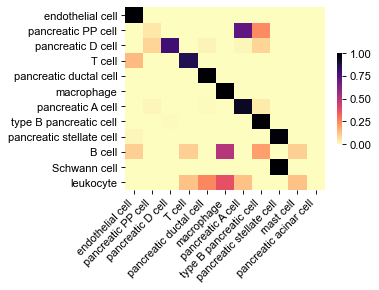

In [7]:
# contingency matrix for query dataset
y_true = obs['celltype'][obs_ids2].values
y_pred = obs['predicted'][obs_ids2].values

ax, contmat = pl.plot_contingency_mat(
    y_true, y_pred, norm_axis=1, 
    order_rows=False, order_cols=False,
)
pl._save_with_adjust(ax.figure, figdir / 'contingency_mat.png')
ax.figure

### Plot heatmap of predicted probabilities

figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(08-15 01.58.31)/figs/heatmap_probas.pdf


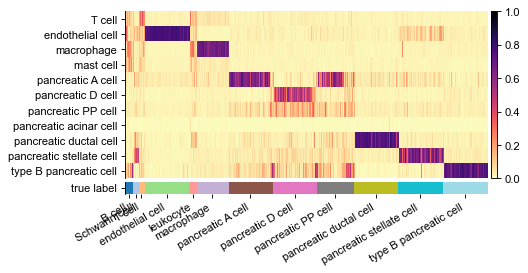

In [8]:
name_label = 'celltype'
cols_anno = ['celltype', 'predicted'][:]
df_probs = obs[list(classes)]


gs = pl.wrapper_heatmap_scores(
        df_probs.iloc[obs_ids2], obs.iloc[obs_ids2], ignore_index=True,
        col_label='celltype', col_pred='predicted',
        n_subsample=50,
        cmap_heat='magma_r',  # if prob_func == 'softmax' else 'RdBu_r'
        fp=figdir / f'heatmap_probas.pdf'
    )

gs.figure

## Get model hidden states

In [9]:
model = trainer.model
feat_dict = trainer.feat_dict  # dpair.get_feature_dict(scale=True) --> CPU
g = trainer.g  # dpair.get_whole_net() --> CPU

# all hidden states
hidden_list = came.model.get_all_hidden_states(trainer.model, feat_dict, g)

Save hidden states

In [10]:
came.save_hidden_states(hidden_list, resdir / 'hidden_list.h5')